# Praca domowa 7
### Mateusz Krzyziński, grupa 2


#### Import pakietów

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Wczytanie danych
Dane pochodzą ze zbioru Wine UCI i zostały wyodrębnione w trzy zbiory: treningowy, walidacyjny i testowy. 

In [2]:
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

In [3]:
train_df.shape

(95, 13)

In [4]:
val_df.shape

(17, 13)

In [5]:
test_df.shape   #dodatkowa kolumna to label - informacja, czy dana obserwacja (wino) jest outlierem 

(17, 14)

In [6]:
X_test_df = test_df.iloc[:, 1:]
y_test = test_df.iloc[:, 0]

In [7]:
train_df

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,12.72,1.75,2.28,22.5,84,1.38,1.76,0.48,1.63,3.300000,0.88,2.42,488
1,13.23,3.30,2.28,18.5,98,1.80,0.83,0.61,1.87,10.520000,0.56,1.51,675
2,12.58,1.29,2.10,20.0,103,1.48,0.58,0.53,1.40,7.600000,0.58,1.55,640
3,12.37,1.17,1.92,19.6,78,2.11,2.00,0.27,1.04,4.680000,1.12,3.48,510
4,13.84,4.12,2.38,19.5,89,1.80,0.83,0.48,1.56,9.010000,0.57,1.64,480
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,12.84,2.96,2.61,24.0,101,2.32,0.60,0.53,0.81,4.920000,0.89,2.15,590
91,12.70,3.87,2.40,23.0,101,2.83,2.55,0.43,1.95,2.570000,1.19,3.13,463
92,12.77,2.39,2.28,19.5,86,1.39,0.51,0.48,0.64,9.899999,0.57,1.63,470
93,12.88,2.99,2.40,20.0,104,1.30,1.22,0.24,0.83,5.400000,0.74,1.42,530


In [8]:
pd.concat([train_df, val_df, X_test_df]).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 0 to 16
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Alcohol                       129 non-null    float64
 1   Malic acid                    129 non-null    float64
 2   Ash                           129 non-null    float64
 3   Alcalinity of ash             129 non-null    float64
 4   Magnesium                     129 non-null    int64  
 5   Total phenols                 129 non-null    float64
 6   Flavanoids                    129 non-null    float64
 7   Nonflavanoid phenols          129 non-null    float64
 8   Proanthocyanins               129 non-null    float64
 9   Color intensity               129 non-null    float64
 10  Hue                           129 non-null    float64
 11  OD280/OD315 of diluted wines  129 non-null    float64
 12  Proline                       129 non-null    int64  
dtypes: flo

W żadnej z ramek danych nie ma brakujących wartości i wszystkie zmienne są numeryczne, zatem jesteśmy w komfortowej sytuacji i możemy przystąpić do modelowania. 

## Wykorzytanie algorytmu GMM do wykrywania outlierów

Celem zadania jest wykorzytanie algorytmu GMM do wykrywania próbek odstających.
Jest to możliwe ze względu na to, że algorytm ten zwraca prawdopodobieństwo przyporządkowania obserwacji do określonego klastra. A więc obserwacje o małym, odstającym od reszty prawdopodobieństwie przyporządkowania można zakwalifikować jako outliery. Właśnie w ten sposób będziemy postępować. 

#### Trening modelu

Na początku wytrenujemy model GMM na zbiorze treningowym - poszukując odpowiedniej liczby komponentów. W tym celu skorzystam z dostępnego w sklearn-owej implementacji GaussianMixture metody `bic`, obliczającej Bayesowskie kryterium informacyjne. Zgodnie z konwencją będziemy dążyć do jego minimalizacji. 

Wykorzystam tutaj domyślny typ macierzy kowariancji - `full` - tak, aby każdy komponent miał swoją własną macierz. 

In [9]:
from sklearn.mixture import GaussianMixture

In [10]:
bic = []
for i in range(1, 10):
    gmm_temp = GaussianMixture(n_components = i, random_state = 42, covariance_type = "full")
    gmm_temp.fit(train_df)
    bic.append(gmm_temp.bic(train_df))

In [11]:
bic

[3902.044526130818,
 4130.146286117928,
 4236.71568075297,
 4304.580333350222,
 4511.176320763237,
 4718.655633317439,
 4314.503424253476,
 4580.929864698331,
 4175.578326118197]

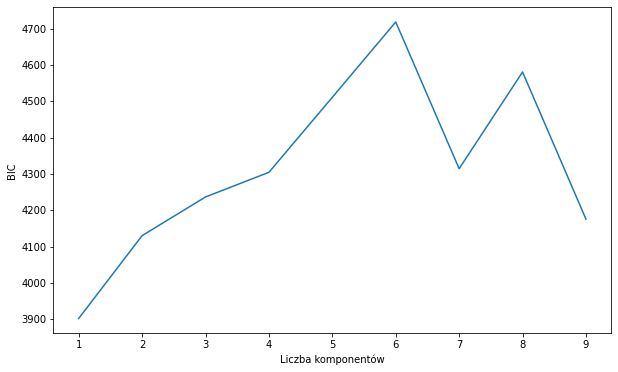

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), bic)
plt.xlabel("Liczba komponentów")
plt.ylabel("BIC")
plt.show()

Zatem pozostajemy przy jednym komponencie, tj. do danych będziemy przyporządkowywać jeden rozkład normalny (oczywiście wielowymiarowy).

In [13]:
best_gmm = GaussianMixture(covariance_type='full', n_components=1, random_state=42)
best_gmm.fit(train_df)

GaussianMixture(random_state=42)

#### Wybór tresholdu

Teraz na podstawie prawdopodobieństw (dokładniej logartymów pstwa) przyporządkowania do klastra określimy treshold stanowiący granicę między inlierami i outlierami. W tym celu wykorzystamy zbiór walidacyjny, w którym wiemy, że znajdują się outliery. Jednocześnie zobaczymy, jak treshold ma się do zbioru treningowego, w którym wiemy, że outlierów nie ma.

In [14]:
probs_train = best_gmm.score_samples(train_df)
probs_val = best_gmm.score_samples(val_df)

In [15]:
probs_train_df = pd.DataFrame(zip(probs_train, ["train"]*len(probs_train)))
probs_val_df = pd.DataFrame(zip(probs_val, ["val"]*len(probs_val)))
probs = pd.concat([probs_train_df, probs_val_df])
probs.reset_index(inplace=True, drop=True)
probs.columns = ["log_prob", "set"]
probs

,log_prob,set
0,-16.114336,train
1,-16.240727,train
2,-17.013200,train
3,-18.532165,train
4,-15.419807,train
...,...,...
107,-32.178425,val
108,-19.973344,val
109,-23.601533,val
110,-16.072479,val


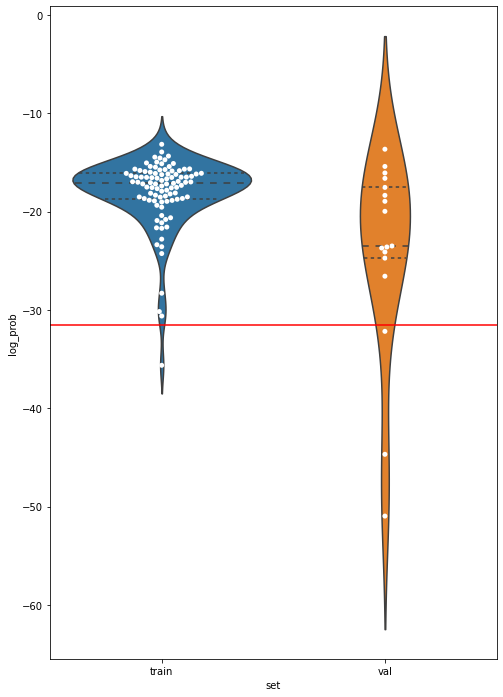

In [16]:
plt.figure(figsize=(8, 12))
sns.violinplot(data = probs, y = "log_prob", x = "set", inner = "quartiles")
sns.swarmplot(data = probs, y = "log_prob", x = "set", color = "white")
plt.axhline(y = -31.5, color = "red")
plt.show()

Wybrany na podstawie rysunku treshold to -31.5, oznaczony czerwoną linią. Widzimy, że w takim wypadku jedna obserwacja ze zbioru treningowego niesłusznie także zakwalifikowana zostałaby jako odstająca, zatem problem identyfikacji outlierów rzeczywiście nie jest łatwy. 

#### Sprawdzenie wyników na zbiorze testowym 

In [17]:
probs_test = best_gmm.score_samples(X_test_df)

In [18]:
y_test_hat = probs_test < - 31.5
y_test_hat = y_test_hat.astype(int)

In [19]:
from sklearn.metrics import f1_score, precision_score, recall_score
results = pd.DataFrame(
    [("precision", precision_score(y_test, y_test_hat)),
    ("recall", recall_score(y_test, y_test_hat)),
    ("F1-score", f1_score(y_test, y_test_hat))],
    columns=["metric", "score"]
)
results

,metric,score
0,precision,0.833333
1,recall,1.000000
2,F1-score,0.909091


In [20]:
n_outliers_real = sum(y_test == 1) # ile powinno być outlierów
n_outliers_pred = sum(y_test_hat == 1) # ile mamy wykrytych
print(f"""Liczba rzeczywistych outlierów w zbiorze testowym: {n_outliers_real}
Liczba obserwacji oznaczonych jako outliery: {n_outliers_pred}""")

Liczba rzeczywistych outlierów w zbiorze testowym: 5
Liczba obserwacji oznaczonych jako outliery: 6


Recall score równy 1 oznacza, że udało nam się prawidłowo wykryć wszystkie outliery. Zatem oznaczyliśmy jedną obserwację nadmiarowo jako outlier (podobnie jak w zbiorze treningowym jedna z obserwacji z wybranym tresholdem byłaby outlierem). Natomiast F1 score na poziomie ok. 91% jest dość zadowalającym wynikiem. Oczywiście w realnym zastosowaniu należałoby się zastanowić, czy bardziej zależy nam na precyzji czy czułości. 

Sprawdzimy jeszcze, jak wyglądają otrzymane wyniki na wykresie. W celu redukcji wymiarów skorzystamy z PCA. 

In [21]:
from sklearn.decomposition import PCA
pca_res = PCA(n_components=2).fit_transform(X_test_df)
res_df = pd.concat([X_test_df, 
                    pd.DataFrame(pca_res, columns = ["pca_x", "pca_y"]), 
                    y_test, 
                    pd.DataFrame(y_test_hat, columns = ["predicted_class"])], 
                   axis=1)
res_df

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,pca_x,pca_y,class,predicted_class
0,13.34,0.94,2.36,17.0,110,2.53,1.30,0.55,0.42,3.17,1.02,1.93,750,17.261366,8.239644,0,0
1,12.00,0.92,2.00,19.0,86,2.42,2.26,0.30,1.43,2.50,1.38,3.12,278,-455.172807,-4.724631,0,0
2,11.84,0.89,2.58,18.0,94,2.20,2.21,0.22,2.35,3.05,0.79,3.08,520,-213.050739,-2.365435,0,0
3,12.47,1.52,2.20,19.0,162,2.50,2.27,0.32,3.28,2.60,1.16,2.63,937,205.413089,55.936004,0,1
4,11.81,2.12,2.74,21.5,134,1.60,0.99,0.14,1.56,2.50,0.95,2.26,625,-107.170774,35.291079,0,0
5,11.82,1.72,1.88,19.5,86,2.50,1.64,0.37,1.42,2.06,0.94,2.44,415,-318.220835,-7.844294,0,0
6,12.25,1.73,2.12,19.0,80,1.65,2.03,0.37,1.63,3.40,1.00,3.17,510,-223.382201,-16.100878,0,0
7,11.87,4.31,2.39,21.0,82,2.86,3.03,0.21,2.91,2.80,0.75,3.64,380,-353.308996,-11.042532,0,0
8,12.93,2.81,2.70,21.0,96,1.54,0.50,0.53,0.75,4.60,0.77,2.31,600,-133.045477,-2.178302,0,0
9,12.87,4.61,2.48,21.5,86,1.70,0.65,0.47,0.86,7.65,0.54,1.86,625,-108.283068,-12.848129,0,0


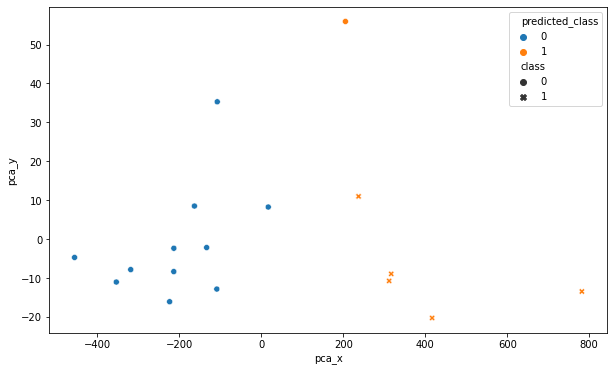

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data = res_df, x = "pca_x", y = "pca_y", hue = "predicted_class", style = "class")
plt.show()

Widzimy, że rzeczywiście jeden punkt został oznaczony fałszywie jako outlier, pozostałe zostały dobrze zaklasyfikowane. Jednocześnie patrząc na wizualizację przy pomocy PCA i wartości cech w ramce danych taka klasyfikacja tej obserwacji nie jest pozbawiona sensu. 

#### Podsumowanie 
Analizując otrzymane rezultaty, w tym wartości metryk, wydaje się, że rzeczywiście algorytm GMM może mieć zastosowanie w wykrywaniu outlierów. Natomiast kluczowy jest dobór odpowiedniego modelu (hiperparametrów - każdy zbiór danych ma inną specyfikę) i tresholdu, który stanowiłby granicę prawdopodobieństwa, poniżej której obserwacje klasyfikujemy jako outliery. 